In [ ]:
# %pip install tensorflow==2.0.0
# %pip install keras==2.3.1

# **Q2**

In [13]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import Dense
from scipy import sparse
import nltk
from nltk.corpus import reuters
import re
import numpy as np

In [3]:
nltk.download('reuters')
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

In [4]:
def get_corpus_text(categories):
    return [" ".join(reuters.words(fid)) for fid in reuters.fileids(categories=categories)]

all_data = get_corpus_text(['crude'])

train_data = all_data[:100]
train_data

["JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said . MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said . The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand . MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said . They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas . Nuclear energy provided the bulk of Japan ' s electric power in the fiscal year ended March 31 , supplying an estimate

In [5]:
# utility.py

def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]

In [6]:
# Perpare X, Y for model

# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in train_data:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

56416it [00:02, 19546.71it/s]


In [12]:
# Define model

embed_size = 2

inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2728)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5458      
_________________________________________________________________
dense_4 (Dense)              (None, 2728)              8184      
Total params: 13,642
Trainable params: 13,642
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train

model.fit(x=X, y=Y, batch_size=256, epochs=10)

Epoch 1/10
56416/56416 [==============================] - 8s 148us/step - loss: 7.7922
Epoch 2/10
56416/56416 [==============================] - 7s 124us/step - loss: 7.3423
Epoch 3/10
56416/56416 [==============================] - 7s 123us/step - loss: 6.8794
Epoch 4/10
56416/56416 [==============================] - 10s 175us/step - loss: 6.6752
Epoch 5/10
56416/56416 [==============================] - 10s 176us/step - loss: 6.6293
Epoch 6/10
56416/56416 [==============================] - 9s 160us/step - loss: 6.6155
Epoch 7/10
56416/56416 [==============================] - 9s 151us/step - loss: 6.6078
Epoch 8/10
56416/56416 [==============================] - 9s 162us/step - loss: 6.6025
Epoch 9/10
56416/56416 [==============================] - 8s 142us/step - loss: 6.5987
Epoch 10/10
56416/56416 [==============================] - 11s 188us/step - loss: 6.5957


In [10]:
# Get embedding dict

# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

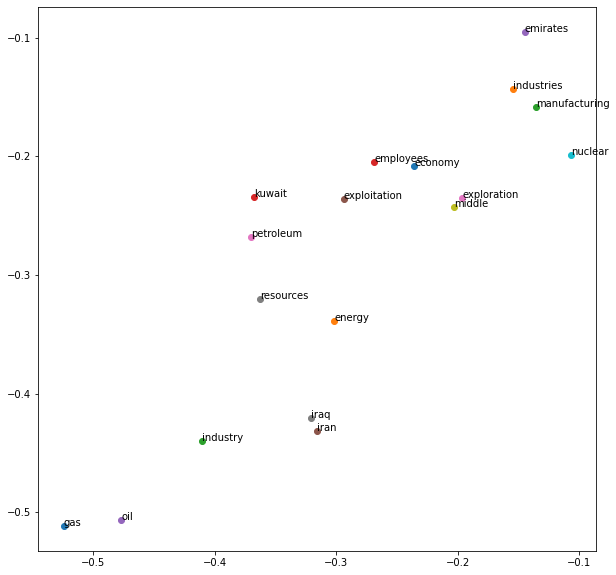

In [11]:
# Plot 

my_words = ['gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 
             'iraq', 'middle', 'nuclear', 'economy', 'industries', 
             'manufacturing', 'employees', 'emirates', 'exploitation', 
             'exploration', 'resources']

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in my_words:
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))   

### find similarity to my words

In [ ]:
my_words = [
  'iran', 'iraq', 'economic', 'industry', 'build', 'gas', 'oil', 
  'energy', 'nuclear', 'employees'
]

for w in my_words:
    similarity = find_similar(w, embedding_dict=embedding_dict)
    print('similar to word {} :'.format(w))
    print()
    print([s[0] for s in similarity])
    print('='*40)
    print()

similar to word iran :

['likely', 'four', 'interest', 'start', 'possibility', 'first', 'month', 'decisions', 'small', 'southland']

similar to word iraq :

['also', 'louisiana', 'oreffice', 'colombia', 'maybe', 'fahd', 'consensus', 'adding', 'miti', 'ended']

similar to word economic :

['leblanc', 'restrictions', 'chemicals', 'bans', 'late', 'undisclosed', 'coasts', 'spending', 'fuels', 'synar']

similar to word industry :

['significantly', 'netbacks', 'quota', 'close', 'subsidiary', 'inventories', 'profits', 'military', 'higher', 'brings']

similar to word build :

['ecuador', 'wanted', 'dlr', 'pumped', 'above', 'it', 'period', 'control', 'domestic', 'budgeted']

similar to word gas :

['lichtblau', 'about', 'remain', 'gasoline', 'spokesman', 'cut', 'natural', 'eia', 'closed', 'murphy']

similar to word oil :

['capacity', 'fell', 'half', 'expect', 'closed', 'agreed', 'pacific', 'stevens', 'murphy', 'remain']

similar to word energy :

['abandoning', 'news', 'nerco', 'edmonton', 'y

# **Q3**

In [186]:
import keras
import cv2
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import backend as K
from keras import layers
from sklearn.utils import shuffle

In [44]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [45]:
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

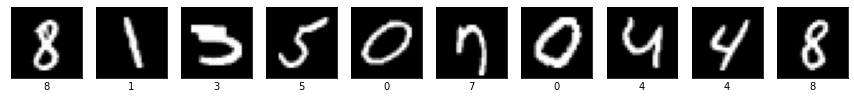

In [46]:
plt.figure(figsize=(15, 1.5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(y_train[i])
    plt.imshow(x_train[i], cmap='gray')

In [47]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)  

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

INPUT_SHAPE = x_train.shape[1:]
x_train.shape, x_test.shape, INPUT_SHAPE

((60000, 28, 28, 1), (10000, 28, 28, 1), (28, 28, 1))

In [49]:
def build_model(model_name):
    
    model = Sequential(name=model_name)
    model.add(layers.InputLayer(INPUT_SHAPE))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

model = build_model('model')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0     

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/15
42000/42000 [==============================] - 74s 2ms/step - loss: 0.2003 - accuracy: 0.9382 - val_loss: 0.1121 - val_accuracy: 0.9663
Epoch 2/15
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.0542 - val_accuracy: 0.9828
Epoch 3/15
42000/42000 [==============================] - 70s 2ms/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.0415 - val_accuracy: 0.9871
Epoch 4/15
42000/42000 [==============================] - 70s 2ms/step - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 5/15
42000/42000 [==============================] - 70s 2ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0524 - val_accuracy: 0.9844
Epoch 6/15
42000/42000 [==============================] - 70s 2ms/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0443 - val_accuracy: 0.9867
Epoch 7/15
42000/42000 [==============================] - 72s 2ms/st

In [91]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 8s 760us/step


[0.03373063611693824, 0.9911999702453613]

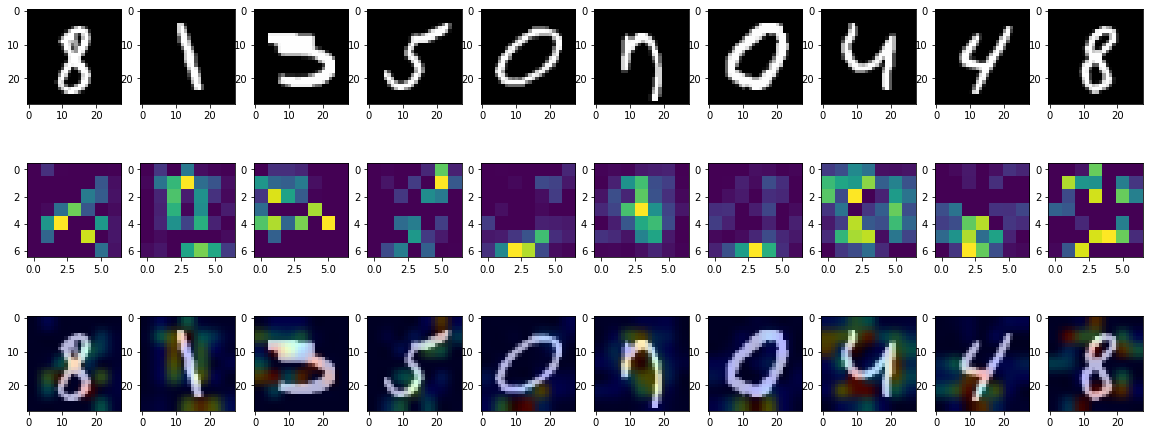

In [188]:
# Grad CAM 

plt.figure(figsize=(20 , 8))

Rows = 10
Columns = 3

for i in range(10):

    label = np.argmax(y_train[i])
    ith_img_output = model.output[:, label]
    last_conv_layer = model.get_layer(index=4)

    grads = K.gradients(ith_img_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    img = x_train[i]
    plt.subplot(3, 10, 0 * 10 + i + 1)
    plt.imshow(img.reshape(28, 28), cmap='gray')

    pooled_grads_value, last_layer_value = iterate([img.reshape(-1, 28, 28, 1)])
    for j in range(64):
        last_layer_value[:, :, j] *= pooled_grads_value[j]
     
    heatmap = np.mean(last_layer_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    plt.subplot(3, 10, 1 * 10 + i + 1)
    plt.imshow(heatmap)

    im_arr = np.uint8(255 * img)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((im_arr.shape[1], im_arr.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + im_arr
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # heatmap = np.uint8(255 * heatmap)
    # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # superimposed_img = heatmap * 0.4 + (img * 255)

    plt.subplot(3, 10, 2 * 10 + i + 1)
    plt.imshow(superimposed_img)
    
plt.show()